In [2]:
import sys
import os
path = os.path.abspath("../")
sys.path.append(path)
print(path)

/home/jovyan


In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset, Sampler, random_split, Dataset, Subset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import random


import src.helpers.MetricUtilities as metrics
import src.data_processing.ImageProducts as ImageProducts

from mtree.mtree import MTree
import mtree.mtree as mtree

import glob
from PIL import Image

import time
import json
import xml.etree.ElementTree as ET

In [105]:
class CustomDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform

        self.imgs_path = "../data/imdb_wiki/"
        file_list = glob.glob(self.imgs_path + "*")
        self.images = []
        for class_path in file_list:
            for dir_path in glob.glob(class_path + "/*"):
                for img_path in glob.glob(dir_path + "/*.jpg"):
                    self.images.append(img_path)

    # Defining the length of the dataset
    def __len__(self):
        return len(self.images)

    # Defining the method to get an item from the dataset
    def __getitem__(self, index):
        image_path = self.images[index]
        image = Image.open(image_path)
        image = transforms.functional.to_grayscale(image)

        # Applying the transform
        if self.transform:
            image = self.transform(image)
        
        return image.squeeze().to('cpu').numpy()

def get_data(size):
    transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])
    return CustomDataset(transform)


class CustomDatasetMStar(Dataset):
    def __init__(self, transform=None):
        self.transform = transform

        self.imgs_path = "/home/jovyan/data/mstar/Padded_imgs/"
        file_list = glob.glob(self.imgs_path + "*")
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "/*.JPG"):
                self.data.append([img_path, class_name])
        #print(self.data)
        self.class_map = {"2S1" : 0, "BRDM_2": 1, "BTR_60": 2, "D7": 3, "SLICY": 4, "T62": 5, "ZIL131": 6, "ZSU_23_4": 7}

    # Defining the length of the dataset
    def __len__(self):
        return len(self.data)

    # Defining the method to get an item from the dataset
    def __getitem__(self, index):
        data_path = self.data[index]
        image = Image.open(data_path[0])
        image = transforms.functional.to_grayscale(image)
        class_id = self.class_map[data_path[1]]
        # Applying the transform
        if self.transform:
            image = self.transform(image)
        
        return image.squeeze().to('cpu').numpy(), class_id
    
def get_data_MStar(size):
    transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])
    return CustomDatasetMStar(transform)

class CustomDatasetSARDet_100k(Dataset):
    def __init__(self, transform=None):
        self.transform = transform

        self.imgs_path = "/home/jovyan/data/SARDet_100k/SARDet_100K/JPEGImages/"
        file_list = glob.glob(self.imgs_path + "*")
        self.data = []

        # with open("../data/SARDet_100k/SARDet_100K/mapping.json") as annotations:
        #     mappings = json.load(annotations)

        for dir_path in file_list:
            for img_path in glob.glob(dir_path + "/*.png"):
                # self.data.append([img_path, mappings[img_path.split("/")[-1]]])
                self.data.append([img_path, "yippee"])
            for img_path in glob.glob(dir_path + "/*.jpg"):
                # self.data.append([img_path, mappings[img_path.split("/")[-1]]])
                self.data.append([img_path, "yippee"])
        

    # Defining the length of the dataset
    def __len__(self):
        return len(self.data)

    # Defining the method to get an item from the dataset
    def __getitem__(self, index):
        data_path = self.data[index]
        image = Image.open(data_path[0])
        image = transforms.functional.to_grayscale(image)
        # class_id = self.class_map[data_path[1]]
        class_id = data_path[1]
        # Applying the transform
        if self.transform:
            image = self.transform(image)
        
        return image.squeeze().to('cpu').numpy(), class_id

def get_data_SARDet_100k(size):
    transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])
    return CustomDatasetSARDet_100k(transform)

In [112]:
import statistics

def packing_dim(r_1, r_2, epsilon, testSample, d):
    l = 1
    L_1 = []
    L_2 = []
    while True:
        S_n = np.random.permutation(testSample)
        C = []
        for i in range(len(S_n)):
            badPoint = False
            for j in range(len(C)):
                if (d(S_n[i], C[j]) < r_1):
                    # print(d(S_n[i], C[j]))
                    badPoint = True
            if (not badPoint):
                # print("not badpoint")
                C.append(S_n[i])
        L_1.append(math.log(len(C)))
        # print(f"L1: {L_1}")
        C = []
        for i in range(len(testSample)):
            badPoint = False
            for j in range(len(C)):
                if (d(S_n[i], C[j]) < r_2):
                    badPoint = True
            if (not badPoint):
                # print("not badpoint")
                C.append(S_n[i])
                # print(f"C: {C}")
        L_2.append(math.log(len(C)))
        # print(f"L2: {L_2}")
        
        num = (np.sum(L_1) / len(L_1)) - (np.sum(L_2) / len(L_2))
        dem = math.log(r_2) - math.log(r_1)
        if (num == 0):
            D_pack = 0
        else:
            D_pack = num / dem
        # D_pack = num / ()
        # print(f"l: {l} and D_pack: {D_pack}")
        if (l > 10):
            # print("l > 10 now")
            numerator = math.sqrt(statistics.variance(L_1) + statistics.variance(L_2))
            denom = math.sqrt(l) * (math.log(r_2) - math.log(r_1))
            # print(numerator / denom)
            if (1.65 * (numerator / denom) < D_pack * (1-epsilon) / 2):
                return D_pack
        l += 1


In [23]:
# list_data = "/home/jovyan/data/ATRNet-STAR_annotations/list_data_all.npz"

# data = np.load(list_data)
# all_data = data["testSample"]

In [115]:
import random
# sample_indices = np.array(random.sample(range(len(all_data), 10)))
sample_indices = np.array(random.sample(range(len(all_data)), 100))
print(sample_indices)
# sample_indices = np.array(random.sample(range(len(entry)), left_len))
testSample = all_data[sample_indices]
# print(testSample.shape)

[ 15529  60449  97980  59486  31454  52360 102327  12904  18251  18411
  43262  65420  31762  40444  36640  61975  77511  95140  70722  41903
  12387  50219  98979  71123  99806  67441  99609  60412  93170   8159
   5908  43552 102101  15429  75741  34694  79007   2941  89730  84916
  73741  79704  54725  73708 103007  49411  95232  15609  98842  95830
  16294  35729  91790  18046  53779  55672  60001  74966  45914   1157
  12571  50326  89358  69647  58708  28036  52105  41982  29479  90757
  43601 103094  22189   9320   6839  57970  43553  65903  22956 101647
  31444  39671  60833  63394  13460  15585  69533  64931  42226  67664
  73603  42453  58458  97806  54475  29507  63966  34996  37654  74101]


In [114]:
import random
IMDB_WIKI_data = get_data(128)
sample_indices = random.sample(range(len(IMDB_WIKI_data)), 10)
sampled_test_data = Subset(IMDB_WIKI_data, sample_indices)

testSample = np.array(sampled_test_data)

KeyboardInterrupt: 

In [ ]:
# import random
# data = get_data_MStar(128)
# sample_indices = random.sample(range(len(data)), 100)
# sampled_test_data = Subset(data, sample_indices)

# testSample = np.array([item[0] for item in sampled_test_data])

In [ ]:
# import random
# data = get_data_SARDet_100k(128)
# sample_indices = random.sample(range(len(data)), 100)
# sampled_test_data = Subset(data, sample_indices)

# testSample = np.array([item[0] for item in sampled_test_data])

In [116]:

r_1 = 0.2
r_2 = 0.1
epsilon = 0.5

D_pack = packing_dim(r_1, r_2, epsilon, testSample, metrics.dist_fft_numba)
print(D_pack)

# For ATRNET 100 its 3.4 in 19s
# For IMDB its 0.18 omg IT CORRELATES!!! in 1m
# For MStar its 0.99 oh thats cool! in 32s
# For SARDET its 0.60 oh funsies. in 24s
# Ok it all actl correlates perfectly lovelyyyy
# Mayb I shld j download random ass datasets to try

2.491356584988785


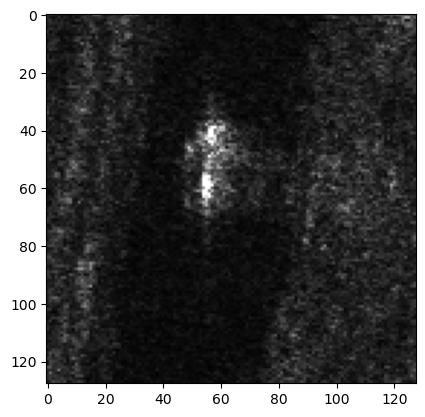

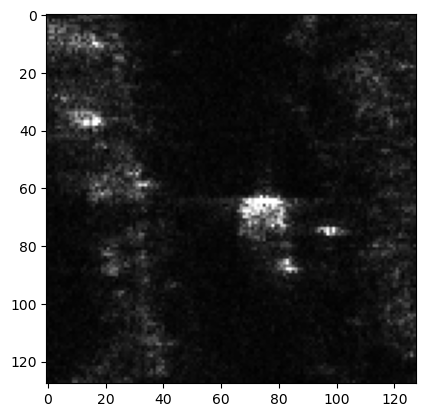

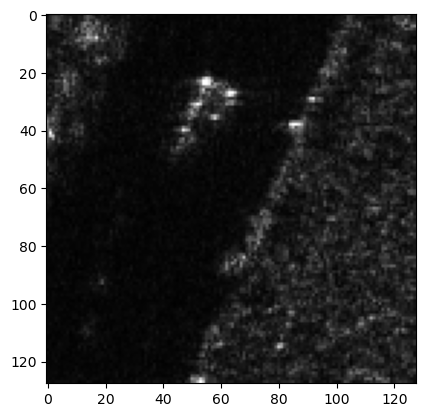

In [82]:
from numpy import random
for i in range(3):
    S_n = random.permutation(testSample)


    plt.imshow(S_n[0], cmap='grey')
    plt.show()



# plt.imshow(S_n[0], cmap='grey')
# plt.show()